In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')  # plot defaults

In [2]:
import xarray as xr
import salem
import numpy as np
import pandas as pd

In [3]:
import oggm.cfg
from oggm import utils, workflow, tasks, graphics
from oggm.sandbox.edu import run_constant_climate_with_bias

In [4]:
# OGGM options
oggm.cfg.initialize(logging_level='WARNING')
oggm.cfg.PATHS['working_dir'] = utils.gettempdir(dirname='WaterResources')
oggm.cfg.PARAMS['min_ice_thick_for_length'] = 1  # a glacier is defined when ice is thicker than 1m
oggm.cfg.PARAMS['store_model_geometry'] = True
# cfg.PARAMS['continue_on_error'] = True

2025-02-25 17:14:04: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2025-02-25 17:14:04: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2025-02-25 17:14:04: oggm.cfg: Multiprocessing: using all available processors (N=16)
2025-02-25 17:14:05: oggm.cfg: PARAMS['min_ice_thick_for_length'] changed from `0.0` to `1`.
2025-02-25 17:14:05: oggm.cfg: PARAMS['store_model_geometry'] changed from `False` to `True`.


In [5]:
# South Cascade
rgi_id = 'RGI60-02.18778'
# # Hintereisferner
# rgi_id = 'RGI60-11.00897'

In [6]:
# We pick the elevation-bands glaciers because they run a bit faster - but they create more step changes in the area outputs
base_url = 'https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.6/L3-L5_files/2023.3/elev_bands/W5E5/RGI62/b_010/L3'
tar_path='C:/Users/bookn/Downloads/Senior-Thesis/Data/SouthCascadeData/RGI60-02.18778.tar.gz'
gdir = workflow.init_glacier_directories([rgi_id], from_tar=tar_path)[0]

2025-02-25 17:14:05: oggm.workflow: Execute entity tasks [GlacierDirectory] on 1 glaciers


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
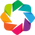

In [7]:
# One interactive plot below requires Bokeh
try:
    import holoviews as hv
    hv.extension('bokeh')
    import geoviews as gv
    import geoviews.tile_sources as gts

    sh = salem.transform_geopandas(gdir.read_shapefile('outlines'))
    out = (gv.Polygons(sh).opts(fill_color=None, color_index=None) * 
           gts.tile_sources['EsriImagery'] * 
           gts.tile_sources['StamenLabels']).opts(width=800, height=500, active_tools=['pan', 'wheel_zoom'])
except:
    # The rest of the notebook works without this dependency
    out = None
out

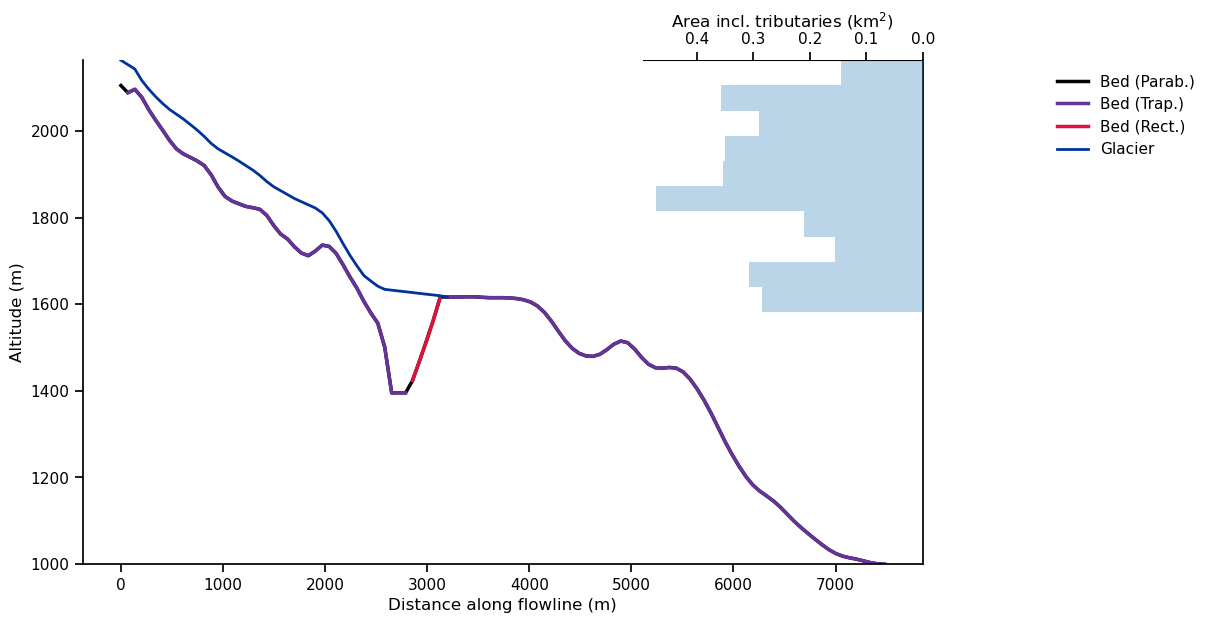

In [8]:
fls = gdir.read_pickle('model_flowlines')
graphics.plot_modeloutput_section(fls);

Text(0, 0.5, 'Temperature bias (°C)')

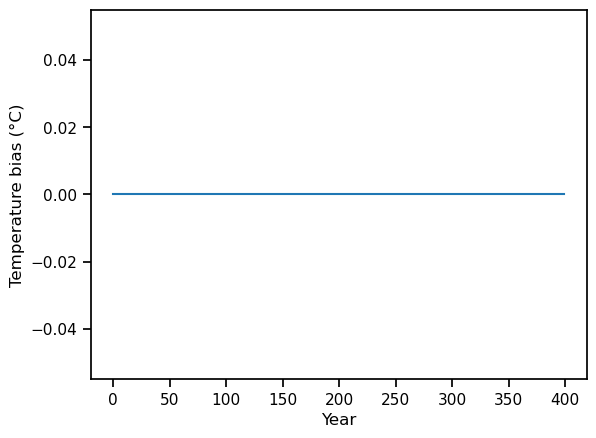

In [9]:
years = np.arange(400)
temp_bias_ts = pd.Series(years * 0. - 0, index=years)
temp_bias_ts.plot(); plt.xlabel('Year'); plt.ylabel('Temperature bias (°C)')

In [10]:
# file identifier where the model output is saved
file_id = '_historical_1984_2024'
oggm.cfg.PARAMS['baseline_climate_y0'] = 1984
oggm.cfg.PARAMS['baseline_climate_y1'] = 2024
# tasks.process_custom_climate_data(gdir, filename='C:/Users/bookn/Downloads/Senior-Thesis/SIA/Data/temp_precip_data.csv')
# Run the glacier model using the historical climate data provided by your tar file.
tasks.run_with_hydro(gdir,                    # Run on the selected glacier
                     run_task=tasks.run_from_climate_data,  # Use historical climate forcing
                     store_monthly_hydro=True,  # Store monthly hydrological outputs
                     output_filesuffix=file_id)  # Identifier for the output file


2025-02-25 17:14:20: oggm.cfg: WARNING: adding an unknown parameter `baseline_climate_y0`:`1984` to PARAMS.
2025-02-25 17:14:20: oggm.cfg: WARNING: adding an unknown parameter `baseline_climate_y1`:`2024` to PARAMS.


In [11]:
with xr.open_dataset(gdir.get_filepath('model_diagnostics', filesuffix=file_id)) as ds:
    # The last step of hydrological output is NaN (we can't compute it for this year)
    ds = ds.isel(time=slice(0, -1)).load()

In [12]:
ds

<xarray.Dataset> Size: 44kB
Dimensions:                       (time: 61, month_2d: 12)
Coordinates:
  * time                          (time) float64 488B 1.959e+03 ... 2.019e+03
    calendar_year                 (time) int32 244B 1959 1960 1961 ... 2018 2019
    calendar_month                (time) int32 244B 1 1 1 1 1 1 ... 1 1 1 1 1 1
    hydro_year                    (time) int32 244B 1959 1960 1961 ... 2018 2019
    hydro_month                   (time) int32 244B 4 4 4 4 4 4 ... 4 4 4 4 4 4
  * month_2d                      (month_2d) int32 48B 1 2 3 4 5 ... 9 10 11 12
    hydro_month_2d                (month_2d) int32 48B 4 5 6 7 8 ... 11 12 1 2 3
    calendar_month_2d             (month_2d) int32 48B 1 2 3 4 5 ... 9 10 11 12
Data variables: (12/21)
    volume_m3                     (time) float64 488B 2.226e+08 ... 2.192e+08
    volume_bsl_m3                 (time) float64 488B 0.0 0.0 0.0 ... 0.0 0.0
    volume_bwl_m3                 (time) float64 488B 0.0 0.0 0.0 ... 0.0 0.0
    area_m2                       (time) float64 488B 2.924e+06 ... 2.915e+06
    length_m                      (time) float64 488B 3.196e+03 ... 3.196e+03
    calving_m3                    (time) float64 488B 0.0 0.0 0.0 ... 0.0 0.0
    ...                            ...
    liq_prcp_on_glacier           (time) float64 488B 1.954e+09 ... 1.731e+09
    liq_prcp_on_glacier_monthly   (time, month_2d) float64 6kB 0.0 0.0 ... 0.0
    snowfall_off_glacier          (time) float64 488B 3.135e+09 ... 2.256e+09
    snowfall_off_glacier_monthly  (time, month_2d) float64 6kB 5.829e+08 ... ...
    snowfall_on_glacier           (time) float64 488B 1.283e+10 ... 8.638e+09
    snowfall_on_glacier_monthly   (time, month_2d) float64 6kB 2.225e+09 ... ...
Attributes:
    description:          OGGM model output
    oggm_version:         1.6.2
    calendar:             365-day no leap
    creation_date:        2025-02-26 00:14:20
    water_level:          0
    glen_a:               5.978638077183011e-24
    fs:                   0
    mb_model_class:       MultipleFlowlineMassBalance
    mb_model_hemisphere:  nh

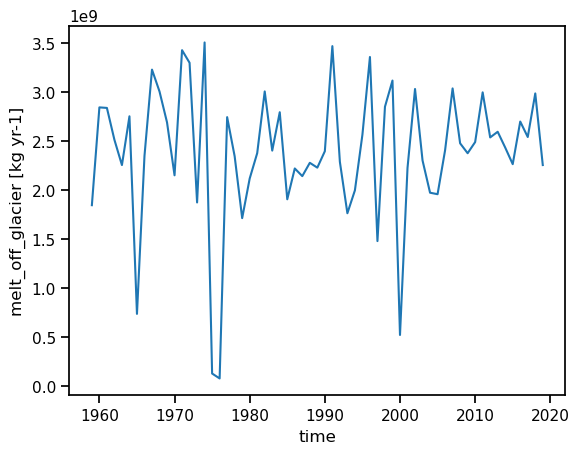

In [13]:
ds.melt_off_glacier.plot(label='Melt (m)', color='C0')

Text(0.5, 0, 'Years')

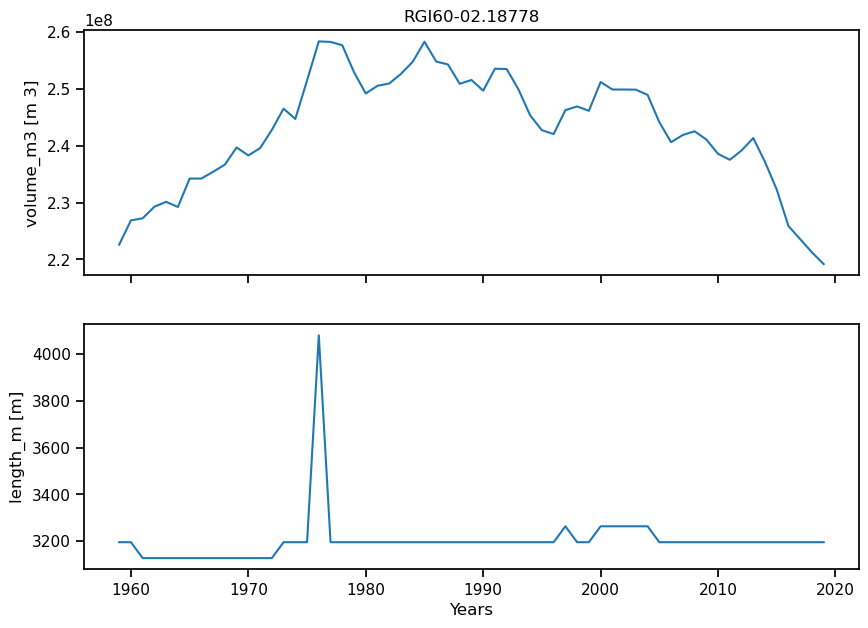

In [14]:
fig, axs = plt.subplots(nrows=2, figsize=(10, 7), sharex=True)
ds.volume_m3.plot(ax=axs[0])
ds.length_m.plot(ax=axs[1])
axs[0].set_xlabel(''); axs[0].set_title(f'{rgi_id}'); axs[1].set_xlabel('Years')

Text(0, 0.5, 'Temperature bias (°C)')

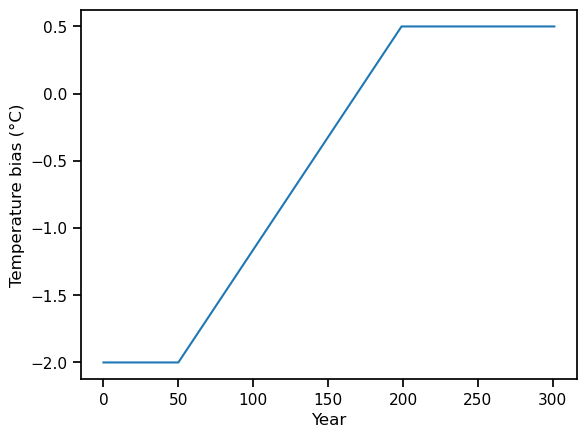

In [15]:
ny_s = 50  # Start
ny_t = 150  # Trend
ny_e = 102  # Stabilisation
temp_bias_ts = np.concatenate([np.full(ny_s, -2.), np.linspace(-2, 0.5, ny_t), np.full(ny_e, 0.5)])
temp_bias_ts = pd.Series(temp_bias_ts, index=np.arange(ny_s + ny_t + ny_e))
temp_bias_ts.plot(); plt.xlabel('Year'); plt.ylabel('Temperature bias (°C)')

In [16]:
# file identifier where the model output is saved
file_id = '_lin_temp'

# We are using the task run_with_hydro to store hydrological outputs along with the usual glaciological outputs
tasks.run_with_hydro(gdir,
                     temp_bias_ts=temp_bias_ts,  # the temperature bias timeseries we just created
                     run_task=run_constant_climate_with_bias,  # which climate scenario? See following notebook for other examples
                     y0=2009, halfsize=10,  # Period which we will average and constantly repeat
                     store_monthly_hydro=True,  # Monthly ouptuts provide additional information
                     init_model_filesuffix='_spinup',  # We want to start from the glacier in equibrium we created earlier
                     output_filesuffix=file_id);  # an identifier for the output file, to read it later

2025-02-25 17:14:22: oggm.sandbox.edu: FileNotFoundError occurred during task run_constant_climate_with_bias_lin_temp on RGI60-02.18778: [Errno 2] No such file or directory: 'C:\\Users\\bookn\\AppData\\Local\\Temp\\OGGM\\WaterResources\\per_glacier\\RGI60-02\\RGI60-02.18\\RGI60-02.18778\\model_geometry_spinup.nc'
2025-02-25 17:14:22: oggm.core.flowline: FileNotFoundError occurred during task run_with_hydro_lin_temp on RGI60-02.18778: [Errno 2] No such file or directory: 'C:\\Users\\bookn\\AppData\\Local\\Temp\\OGGM\\WaterResources\\per_glacier\\RGI60-02\\RGI60-02.18\\RGI60-02.18778\\model_geometry_spinup.nc'


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\bookn\\AppData\\Local\\Temp\\OGGM\\WaterResources\\per_glacier\\RGI60-02\\RGI60-02.18\\RGI60-02.18778\\model_geometry_spinup.nc'

In [ ]:
with xr.open_dataset(gdir.get_filepath('model_diagnostics', filesuffix=file_id)) as ds:
    # The last step of hydrological output is NaN (we can't compute it for this year)
    ds = ds.isel(time=slice(0, -1)).load()

Text(0, 0.5, 'Temperature bias (°C)')

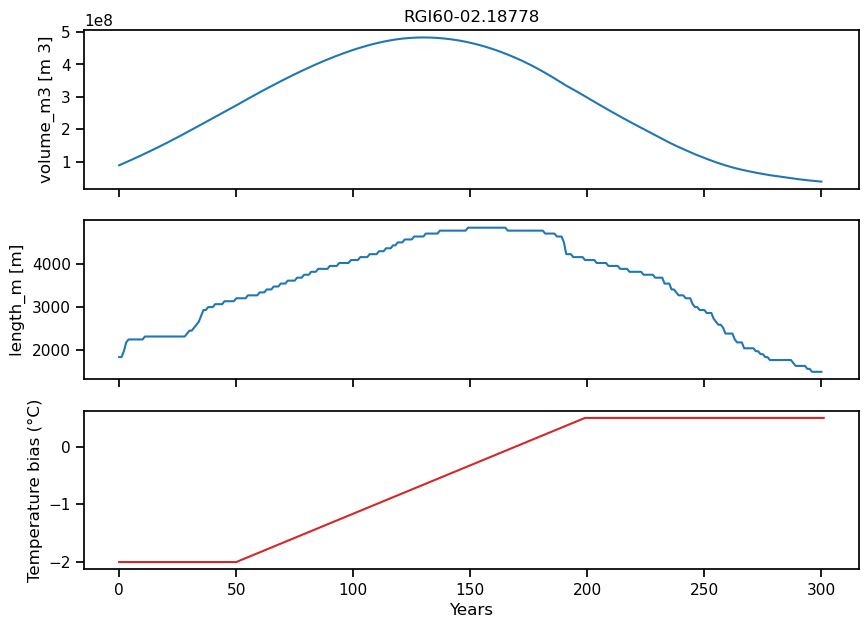

In [ ]:
fig, axs = plt.subplots(nrows=3, figsize=(10, 7), sharex=True)
ds.volume_m3.plot(ax=axs[0])
ds.length_m.plot(ax=axs[1])
temp_bias_ts.plot(ax=axs[2], c='C3')
axs[0].set_xlabel(''); axs[0].set_title(f'{rgi_id}'); axs[1].set_xlabel(''); axs[2].set_xlabel('Years'); axs[2].set_ylabel('Temperature bias (°C)')